# Davos Data Project

## Goal:
### Generate data to support a story that demonstrates the value of Gecko's unique dataset


Hypotheses:
- Extreme Weather leads to outages due to increased energy demand and stress on the grid
    - Winter weather events , extreme cold
    - Summer and extreme heat
- 

## Table of Contents:

1. Data Overview
    - data
2. Environment Setup
3. Data Loading & Preprocessing
4. EDA & Visualization

## 1. Data Overview

- data
    - raw_data
        - AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx
            - AEP boiler tube leaks Jan 2011 - Aug 2022
            - Source: AEP, Wolpa
        - All US Boilers.csv
            - US Boilers
            - Source: IIR, Wolpa
        - Duke Fleet Boiler tube failure data 2005 - 2020.csv
            - Duke boiler tube leaks 2005 - 2020
            - Source: Duke, Connor
        - salesforce.csv
            - Gecko Salesforce data
            - Source: Gecko Salesforce
        - portalservice_power_units
            - all power industry units in portal data
            - Source: Gecko portal-service

## 2. Environment Setup

In [142]:
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import zlib

Matplotlib Style:

In [18]:
plt.style.use('dark_background')

Get Current Working Directory:

In [17]:
wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project


In [131]:
pd.set_option('display.max_rows', 1000)

## 3. EDA and Visualization

### Source 1:
AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx

In [8]:
aep_df = pd.read_excel(r"data/raw_data/AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx", "Data")

In [9]:
aep_df.head()

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00.000,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.000000,24.200000,16335.000000,Keep
1,Indiana Michigan Power Co. (AEP),Rockport,Rockport 1,2010-12-31 19:42:59.999,2011-01-05 10:10:00.000,U2,114.0,Boiler,Boiler Tube Leaks,1005,Generating tubes,N,1320.000000,106.166667,140140.000000,Keep
2,Dayton Power and Light Co.,J. M. Stuart,Stuart 4,2011-01-01 00:00:00.000,2011-01-06 07:40:59.999,U1,1.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,576.999974,127.683333,73673.283333,Keep
3,Duke Energy Commercial Asset Management,W. H. Zimmer,Zimmer 1,2011-01-04 03:21:00.000,2011-01-07 04:24:59.999,U1,2.0,Boiler,Boiler Tube Leaks,1050,Second superheater,Y,1300.000046,73.066667,94986.666667,Keep
4,Ohio Valley Elec Corp/Indiana Kentucky Elec Co...,Clifty Creek,Clifty Creek 4,2011-01-04 23:59:00.000,2011-01-08 03:46:00.000,U3,3.0,Boiler,Boiler Tube Leaks,1020,Convection pass wall (water tubes only),N,205.000088,75.783333,15535.583333,Keep


In [19]:
aep_df.shape

(2195, 16)

In [20]:
aep_df.columns

Index(['Utility Name', 'Plant Name', 'Unit Name', 'Event Start Timestamp',
       'Event End Timestamp', 'Event Type Code', 'Event Number', 'System Name',
       'Component Name', 'Cause Code', 'Cause Description', 'Retired Flag',
       'v_Event_Reduction', 'NERC Equivalent Hours', 'NERC MWH Loss',
       'Unnamed: 15'],
      dtype='object')

In [26]:
set(aep_df['System Name'])

{'Boiler', 'HRSG Boiler', 'Heat Recovery Steam Generator (HRSG)'}

In [27]:
set(aep_df['Cause Description'])

{'Boiler screen, wing wall, or slag screen (water tubes only)',
 'Convection pass wall (water tubes only)',
 'Cyclone furnace (in cyclone area only)',
 'Economizer',
 'External reheater link tubing',
 'External superheater link tubing',
 'First reheater',
 'First superheater',
 'Generating tubes',
 'HP Evaporator tubes',
 'HP economizer',
 'HP reheater',
 'HP superheater',
 'IP reheater',
 'LP Evaporator tubes',
 'LP economizer',
 'Other HRSG tube problems',
 'Other boiler tube leaks',
 'Platen superheater',
 'Second reheater',
 'Second superheater',
 'Steam generating tubes between steam drum and mud drum',
 'Waterwall (Furnace wall)'}

In [29]:
aep_df['Plant Name'].nunique()

39

In [48]:
aep_df[aep_df['Retired Flag']=='Y']['Plant Name'].nunique()

22

In [49]:
aep_df[aep_df['Retired Flag']=='N']['Plant Name'].nunique()

26

### Let's filter out the retired plants

In [128]:
active_aep_df = aep_df[aep_df['Retired Flag']=='N']

In [45]:
aep_df['Event Start Timestamp'].min()

Timestamp('2010-09-27 07:44:00')

In [46]:
aep_df['Event Start Timestamp'].max()

Timestamp('2022-06-25 06:25:00')

In [96]:
aep_df['Outage Month'] = pd.to_datetime(aep_df['Event Start Timestamp']).dt.month
aep_df['Outage Week'] = pd.to_datetime(aep_df['Event Start Timestamp']).dt.isocalendar().week

In [97]:
aep_month_outage_df = aep_df.groupby(['Outage Month'])['Event Start Timestamp'].nunique().to_frame().reset_index()

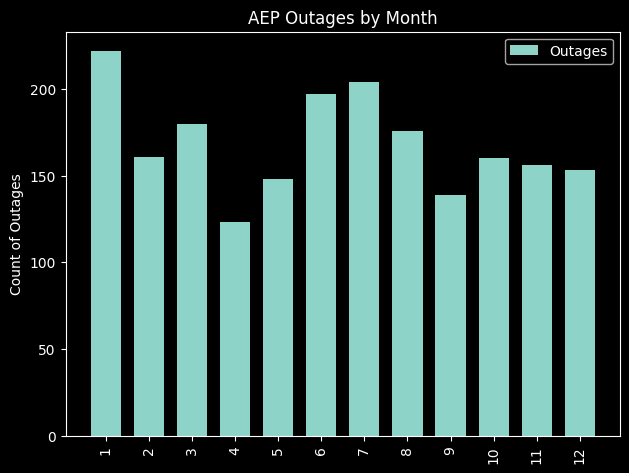

In [99]:
fig, ax = plt.subplots()

x = aep_month_outage_df["Outage Month"]
y = aep_month_outage_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(aep_month_outage_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [100]:
aep_week_outage_df = aep_df.groupby(['Outage Week'])['Event Start Timestamp'].nunique().to_frame().reset_index()

In [37]:
plant_outages_df = aep_df.groupby(['Plant Name'])['Event Start Timestamp'].nunique().to_frame().reset_index().sort_values(by='Event Start Timestamp', ascending=False)

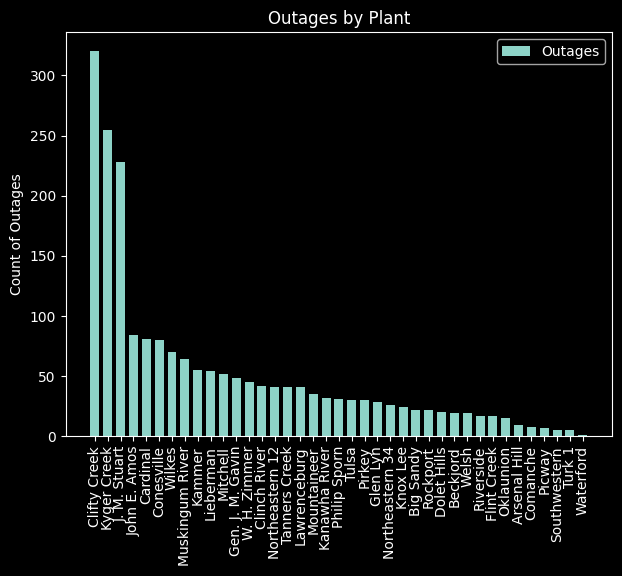

In [38]:
fig, ax = plt.subplots()

x = plant_outages_df["Plant Name"]
y = plant_outages_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Outages by Plant')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [39]:
outage_duration_df = aep_df.groupby(['Plant Name'])['NERC Equivalent Hours'].sum().to_frame().reset_index().sort_values(by='NERC Equivalent Hours', ascending=False)

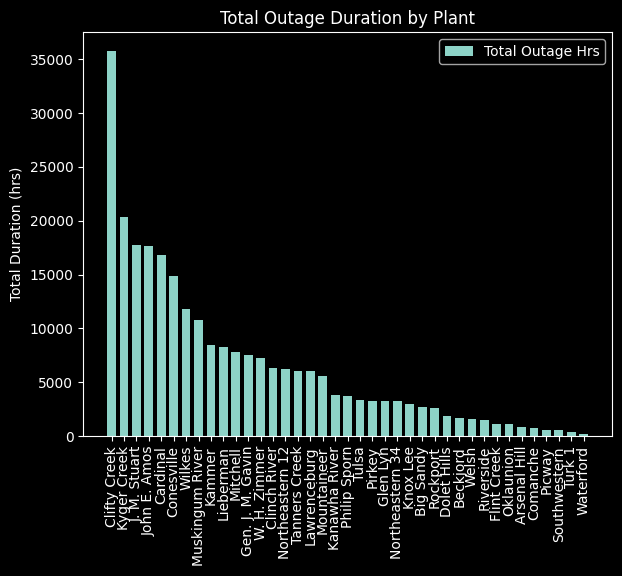

In [41]:
fig, ax = plt.subplots()

x = outage_duration_df["Plant Name"]
y = outage_duration_df["NERC Equivalent Hours"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total Outage Hrs')
ax.set_title('Total Outage Duration by Plant')
ax.set_ylabel('Total Duration (hrs)')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [43]:
outage_mwh_df = aep_df.groupby(['Plant Name'])['NERC MWH Loss'].sum().to_frame().reset_index().sort_values(by='NERC MWH Loss', ascending=False)

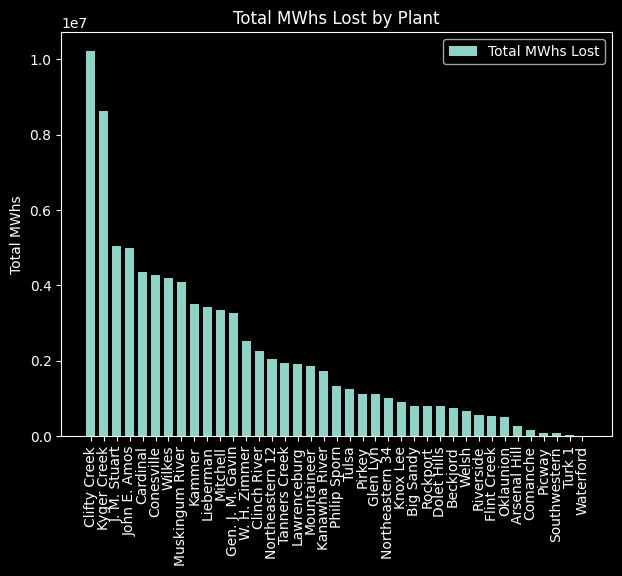

In [44]:
fig, ax = plt.subplots()

x = outage_mwh_df["Plant Name"]
y = outage_mwh_df["NERC MWH Loss"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total MWhs Lost')
ax.set_title('Total MWhs Lost by Plant')
ax.set_ylabel('Total MWhs')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [28]:
aep_df['Unit Name'].nunique()

106

In [21]:
set(aep_df['Utility Name'])

{'AEP Generation Resources Inc',
 'AEP West Central Louisianna Electric Co',
 'AEP West Public Service Co of Oklahoma',
 'AEP West Southwestern Electric Power Co',
 'AEP West Texas North Company',
 'Appalachian Power Co. (AEP)',
 'Central Operating Company (AEP)',
 'Dayton Power and Light Co.',
 'Duke Energy Commercial Asset Management',
 'Indiana Michigan Power Co. (AEP)',
 'Kentucky Power Co. (AEP)',
 'Ohio Power Co. (AEP)',
 'Ohio Valley Elec Corp/Indiana Kentucky Elec Corp (OVEC IKEC)',
 'Ohio Valley Electric Corporation (OVEC)'}

In [22]:
duke_slice_df = aep_df[aep_df['Utility Name']=='Duke Energy Commercial Asset Management']

In [23]:
duke_slice_df.shape

(64, 16)

In [25]:
set(duke_slice_df['Plant Name'])

{'Beckjord', 'W. H. Zimmer'}

NOTES:

- Beckjord - https://en.wikipedia.org/wiki/Beckjord_Power_Station
    - previously joint owned, decommisioned in 2014
- Zimmer - https://en.wikipedia.org/wiki/William_H._Zimmer_Power_Station
    - Vistra Corp

### Source 2:
All US Boilers.csv

In [10]:
us_boilers_df = pd.read_csv(r"data/raw_data/All US Boilers.csv")

In [11]:
us_boilers_df.head()

,PARENTNAME,OWNER_NAME,OPER_NAME,PLANT_NAME,PHYS_CITY,P_COUNTY,UNIT_STATE,P_ST_NAME,P_COUNTRY,MARKET_REG,...,TEMP,TEMP_UOM,TEMP_CEL,DESIGNFIRM,CONSTFIRM,MMBTU_HR,KO_YEAR,LATITUDE,LONGITUDE,COGEN_CHP
0,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,...,1010.0,deg F,543.0,AEP Pro Serv,AEP Pro Serv,NaN,NaN,38.934700,-82.115800,0
1,American Electric Power Company Incorporated,Appalachian Power Company,Appalachian Power Company,John Amos Power Station,Winfield,Putnam,WV,West Virginia,U.S.A.,Mid Atlantic,...,1000.0,deg F,538.0,American Electric Power,American Electric Power,11936.0,NaN,38.473069,-81.822458,0
2,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,...,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
3,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,...,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
4,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,...,1010.0,deg F,543.0,Black & Veatch,NaN,NaN,NaN,38.934700,-82.115800,0


In [50]:
us_boilers_df.shape

(2538, 48)

In [51]:
us_boilers_df.columns

Index(['PARENTNAME', 'OWNER_NAME', 'OPER_NAME', 'PLANT_NAME', 'PHYS_CITY',
       'P_COUNTY', 'UNIT_STATE', 'P_ST_NAME', 'P_COUNTRY', 'MARKET_REG',
       'WORLD_REG', 'IND_CODE_DESC', 'SIC_CODE', 'PLANT_ID', 'UNIT_NAME',
       'UNIT_ID', 'UNIT_TYPE', 'OUT_DESIGN', 'KO_DATE', 'STARTUP', 'STARTYEAR',
       'SHUTDOWN', 'PRIM_FUEL', 'SECND_FUEL', 'FUEL_GROUP', 'HEAT_RATE',
       'PWR_USAGE', 'U_STATUS', 'BOIL_NAME', 'BOILERTYPE', 'BMFR_NAME',
       'BOIL_INFO', 'STEAM', 'STEAM_UOM', 'STEAM_TON', 'PRESSURE', 'PRES_UOM',
       'PRES_BAR', 'TEMP', 'TEMP_UOM', 'TEMP_CEL', 'DESIGNFIRM', 'CONSTFIRM',
       'MMBTU_HR', 'KO_YEAR', 'LATITUDE', 'LONGITUDE', 'COGEN_CHP'],
      dtype='object')

In [57]:
us_boilers_df['PARENTNAME'].nunique()

320

In [58]:
us_boilers_df['UNIT_ID'].nunique()

2286

In [64]:
us_boilers_df.loc[:, ('SHUTDOWN', 'U_STATUS', 'KO_YEAR')].head()

,SHUTDOWN,U_STATUS,KO_YEAR
0,1-Dec-35,Operational,NaN
1,1-Dec-33,Operational,NaN
2,31-Dec-28,Operational,1968.0
3,31-Dec-26,Operational,1968.0
4,1-Dec-35,Operational,NaN


In [65]:
set(us_boilers_df['U_STATUS'])

{'Closed', 'Mothballed', 'Operational', 'Removed', 'Shuttered'}

In [71]:
us_boilers_df[us_boilers_df['U_STATUS']=='Operational'].groupby(['PARENTNAME'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False) #.sum()

,UNIT_ID
PARENTNAME,
American Electric Power Company Incorporated,43
Vistra Energy Corporation,41
Xcel Energy Incorporated,35
Southern Company,29
Duke Energy Corporation,29
...,...
City of Kansas City,1
Libra Group,1
Lancaster County Solid Waste Management Authority,1


In [55]:
us_boilers_df.groupby(['FUEL_GROUP', 'PRIM_FUEL', 'SECND_FUEL'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

UNIT_ID
FUEL_GROUP  PRIM_FUEL          SECND_FUEL                               
Natural Gas Natural Gas        Fuel Oil No. 2 Distillate Diesel      209
                               Fuel Oil No. 6 Residual               148
Coal        Coal Subbituminous Natural Gas                           142
            Coal Bituminous    Fuel Oil No. 2 Distillate Diesel      131
                               Natural Gas                           115
...                                                                  ...
Natural Gas Natural Gas        Hydrogen                                1
Fuel Oil    Petroleum Coke     Wood                                    1
            Tire Derived Fuel  Propane                                 1
Coal        Coal Subbituminous Coke-Oven Gas                           1
            Coal Waste         Coal Subbituminous                      1

[95 rows x 1 columns]

In [56]:
us_boilers_df.groupby(['FUEL_GROUP'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

,UNIT_ID
FUEL_GROUP,
Coal,1179
Natural Gas,768
Fuel Oil,200
Renewable Energy,139


### Source 3:
Duke Fleet Boiler tube failure data 2005 - 2020.csv

In [80]:
duke_df = pd.read_csv(r"data/raw_data/Duke Fleet Boiler tube failure data 2005 - 2020.csv")

In [88]:
duke_df.head()

,Event ID,Station-Unit,Start Date,Cause Code Name,IsRepeat,TimeBetweenFailure,Outage Week
0,31289,East Bend Steam-2,1/4/05 9:41,Waterwall (Furnace wall) A,False,NaN,1
1,31290,East Bend Steam-2,1/4/05 10:23,Waterwall (Furnace wall) A,True,0.700000,1
2,34085,Gibson Steam-3,1/14/05 11:31,Waterwall (Furnace wall) A,False,NaN,2
3,34086,Gibson Steam-3,1/14/05 14:11,Waterwall (Furnace wall) A,True,2.666667,2
4,34087,Gibson Steam-3,1/16/05 2:41,Waterwall (Furnace wall) A,True,36.500000,2


In [89]:
duke_df['Outage Month'] = pd.to_datetime(duke_df['Start Date']).dt.month

In [98]:
duke_df['Outage Week'] = pd.to_datetime(duke_df['Start Date']).dt.isocalendar().week

In [91]:
duke_month_outages_df = duke_df.groupby(['Outage Month'])['Event ID'].nunique().to_frame().reset_index()

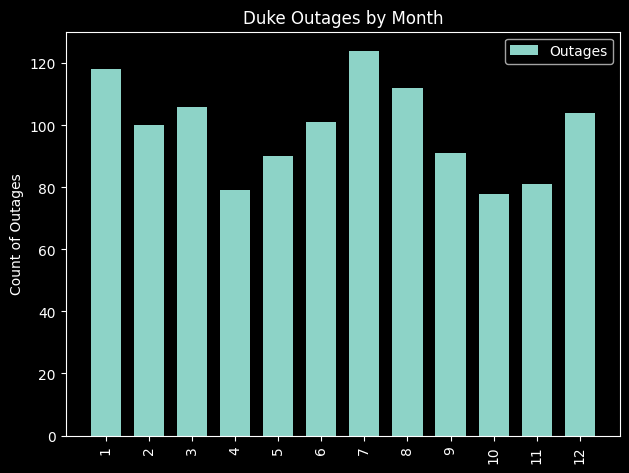

In [92]:
fig, ax = plt.subplots()

x = duke_month_outages_df["Outage Month"]
y = duke_month_outages_df["Event ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(duke_month_outages_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [86]:
duke_week_outages_df = duke_df.groupby(['Outage Week'])['Event ID'].nunique().to_frame().reset_index()

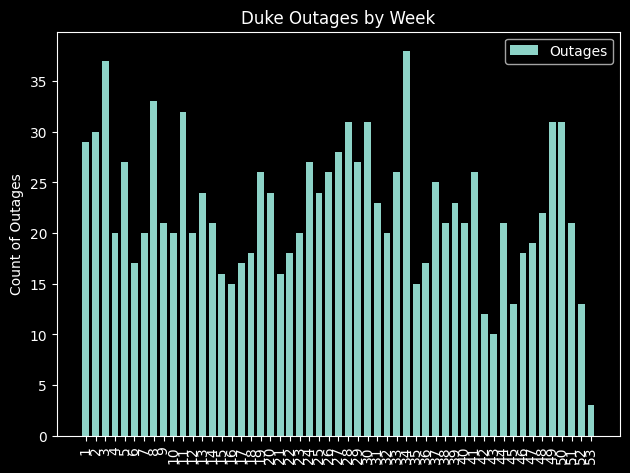

In [87]:
fig, ax = plt.subplots()

x = duke_week_outages_df["Outage Week"]
y = duke_week_outages_df["Event ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Week')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(duke_week_outages_df["Outage Week"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [14]:
salesforce_df = pd.read_csv(r"data/raw_data/salesforce.csv")

In [15]:
salesforce_df.head()

,Nominal Thickness (inches),Height/Length,# of Tubes,Tube OD,C2C,Inspection Asset Component Name,Inspection Service,Robot,Inspection: Start Date,Inspection: End Date,Asset: Asset Name,Asset Component Name
0,NaN,41.0,79.0,3.0,4.5,Front Wall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Front Wall
1,NaN,78.0,78.0,2.5,3.0,Left Sidewall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Left Sidewall
2,NaN,78.0,79.0,3.0,4.5,Rear Wall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Rear Wall
3,NaN,78.0,78.0,2.5,3.0,Right Sidewall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Right Sidewall
4,0.2,30.0,100.0,2.5,3.0,Waterwall - RUG,RUG,TOKA 4,11/7/2022,11/9/2022,#2 Recovery Boiler,Waterwall


In [72]:
salesforce_df.columns

Index(['Nominal Thickness (inches)', 'Height/Length', '# of Tubes', 'Tube OD',
       'C2C', 'Inspection Asset Component Name', 'Inspection Service', 'Robot',
       'Inspection: Start Date', 'Inspection: End Date', 'Asset: Asset Name',
       'Asset Component Name'],
      dtype='object')

In [109]:
salesforce_df['Nominal Thickness (inches)'].describe()

count    668.000000
mean       0.259373
std        0.364204
min       -0.001000
25%        0.203000
50%        0.240000
75%        0.250000
max        4.500000
Name: Nominal Thickness (inches), dtype: float64

In [110]:
salesforce_df['Nominal Thickness (inches)'].median()

0.24

In [113]:
salesforce_df['# of Tubes'].describe()

count    643.000000
mean      94.519440
std      124.327189
min        1.000000
25%       20.000000
50%       52.000000
75%      103.000000
max      880.000000
Name: # of Tubes, dtype: float64

In [112]:
salesforce_df[salesforce_df['Nominal Thickness (inches)'] > 0.25]['Asset: Asset Name'].nunique()

22

In [107]:
salesforce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Nominal Thickness (inches)       668 non-null    float64
 1   Height/Length                    644 non-null    float64
 2   # of Tubes                       643 non-null    float64
 3   Tube OD                          716 non-null    float64
 4   C2C                              717 non-null    float64
 5   Inspection Asset Component Name  728 non-null    object 
 6   Inspection Service               727 non-null    object 
 7   Robot                            624 non-null    object 
 8   Inspection: Start Date           644 non-null    object 
 9   Inspection: End Date             644 non-null    object 
 10  Asset: Asset Name                728 non-null    object 
 11  Asset Component Name             728 non-null    object 
dtypes: float64(5), object(

In [73]:
set(salesforce_df['Asset: Asset Name'])

{'#1 Power Boiler',
 '#2 Recovery Boiler',
 '23-H-3-CO Boiler 4 Water wall and Bullnose',
 'AES Petersburg - Unit 3 Boiler',
 'AES Petersburg - Unit 4 Boiler',
 'Angamos Boiler',
 'B&W waste boiler',
 'BFB Boiler',
 'BFB Boiler (128MW)',
 'BPCP Boiler',
 'Bark Boiler',
 'Boiler',
 'Boiler #1',
 'Boiler 10',
 'Boiler 6',
 'Boiler 7',
 'Boiler B',
 'Boiler C',
 'Boiler Slopes',
 'Boiler Unit #4',
 'Boiler Unit 1',
 'Boiler Unit 2',
 'Boiler Unit 3',
 'Boiler Unit 5',
 'CFB (Cilegon ST 02)  150MW',
 'CFB Boiler',
 'CFB Boiler #1',
 'CFB Boiler #2',
 'CFB Boiler NO2',
 'CFB Unit #1',
 'CFB boiler - (150MW Thermal/50MW Electric))',
 'CFB by SFW (150Mw heating / ~50MW electrical))',
 'CFBC biomass boiler',
 'Cilegon ST 01 - CFB boiler',
 'Coal Boiler',
 'Covanta Montgomery - Unit #1 Boiler',
 'Covanta Montgomery - Unit #3 Boiler',
 'Cross - Unit 4',
 'Cross Unit 4 Waterwalls',
 'Economizer tube bank',
 'FD4',
 'Furnace 5',
 'Gas Boiler',
 'Ingredion Argo - Boiler #10',
 'K11 PC Boiler',
 'Le

### Source 5:
portalservice_power_units.json

In [133]:
with open(r'data/raw_data/portalservice_power_inspections_2022.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [134]:
portalservice_power_inspections_2022_df = pd.json_normalize(d)

In [135]:
portalservice_power_inspections_2022_df.head()

,Inspection.id,Inspection.zero_offset,Inspection.show_excel,Inspection.target_release_time,Inspection.inspection_type,Inspection.sort_order,Inspection.ndt_method_type,Inspection.data_import,Inspection.name,Inspection.sales_robotic_service_id,...,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,4060,None,1,None,wall_thickness,3241,ut,0,None,NaN,...,38,West Lafayette,wade-utility-plant-c9e652,insp_purdue_wade,38,customer_logos/purdue.png,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Purdue University,purdue-university-7a0ab8
1,4061,None,1,None,coating_thickness,3242,mi,0,None,NaN,...,38,West Lafayette,wade-utility-plant-c9e652,insp_purdue_wade,38,customer_logos/purdue.png,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Purdue University,purdue-university-7a0ab8
2,4067,None,1,None,wall_thickness,3228,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff
3,4068,None,1,None,wall_thickness,3229,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff
4,4069,None,1,None,wall_thickness,3230,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff


In [136]:
portalservice_power_inspections_2022_df.columns

Index(['Inspection.id', 'Inspection.zero_offset', 'Inspection.show_excel',
       'Inspection.target_release_time', 'Inspection.inspection_type',
       'Inspection.sort_order', 'Inspection.ndt_method_type',
       'Inspection.data_import', 'Inspection.name',
       'Inspection.sales_robotic_service_id', 'Inspection.date',
       'Inspection.component_id', 'Inspection.notes', 'Inspection.external_id',
       'Inspection.slug', 'Inspection.demo', 'Inspection.read_only',
       'Inspection.status', 'Inspection.job_id', 'Component.id',
       'Component.tube_diameter', 'Component.tube_spacing',
       'Component.sea_level', 'Component.shell_diameter',
       'Component.slope_angle', 'Component.lat', 'Component.lng',
       'Component.material_type', 'Component.wall_nominal_thickness',
       'Component.wall_warning_thickness',
       'Component.coating_nominal_thickness',
       'Component.coating_warning_thickness', 'Component.component_type',
       'Component.sales_asset_type_id', 'Com

In [140]:
distinct_2022_power_inspection_slugs = list(set(portalservice_power_inspections_2022_df['Inspection.slug']))

In [141]:
len(distinct_2022_power_inspection_slugs)

266

### Get actual inspection data

In [ ]:
prod = {
    "url_start": "https://portal-service.cloud.geckorobotics.com/api/v1/deliverables/",
    "url_end": "/binned_plot_data.json", 
    "token": "eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IkVpeTN0a0l0bzZ0SDFTZ1VZdUdXVCJ9.eyJpc3MiOiJodHRwczovL2dlY2tvcm9ib3RpY3MudXMuYXV0aDAuY29tLyIsInN1YiI6Imdvb2dsZS1vYXV0aDJ8MTAxODIxNjU3MzQ0ODI0ODQxMjA5IiwiYXVkIjpbImNsb3VkLmdlY2tvcm9ib3RpY3MuY29tIiwiaHR0cHM6Ly9nZWNrb3JvYm90aWNzLnVzLmF1dGgwLmNvbS91c2VyaW5mbyJdLCJpYXQiOjE2NzMxMTI3NjUsImV4cCI6MTY3MzE5OTE2NSwiYXpwIjoiSm1la3lLS0RsM2liRzdQbExRY2JLWHZoekx1UTRaQ08iLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGVtYWlsIiwicGVybWlzc2lvbnMiOlsiY29sbGVjdGlvbnM6M2RfbW9kZWxzOmVkaXQiLCJjb2xsZWN0aW9uczphZG5vYy1hYnUtZGhhYmktbmF0aW9uYWwtb2lsLWNvbXBhbnktMmE1MzY0OmVkaXQiLCJjb2xsZWN0aW9uczphZXAtYTgyZjE4OmVkaXQiLCJjb2xsZWN0aW9uczphZXMtZWE0ZjMwOmVkaXQiLCJjb2xsZWN0aW9uczpiYXNmLTBmMmNiZTplZGl0IiwiY29sbGVjdGlvbnM6Y2hldnJvbi0wMWE1M2Y6ZWRpdCIsImNvbGxlY3Rpb25zOmNvbWJpbmVkX2NvbXBvbmVudF9kZnM6ZWRpdCIsImNvbGxlY3Rpb25zOmRvbXRhci03NDVhNWE6ZWRpdCIsImNvbGxlY3Rpb25zOmR1a2UtN2YyZmFmOmVkaXQiLCJjb2xsZWN0aW9uczplYmVuc2J1cmctcG93ZXItY29tcGFueS0wZTEyMWY6ZWRpdCIsImNvbGxlY3Rpb25zOmV4eG9uLTdmZDJhYjplZGl0IiwiY29sbGVjdGlvbnM6ZmRlLWRlbW86ZWRpdCIsImNvbGxlY3Rpb25zOmdlb3JnaWEtcGFjaWZpYy1hMWVjNTM6ZWRpdCIsImNvbGxlY3Rpb25zOm1hbnVhbF9pbnNwZWN0aW9uczplZGl0IiwiY29sbGVjdGlvbnM6bm9uc3BlY2lmaWMtY3VzdG9tZXI6ZWRpdCIsImNvbGxlY3Rpb25zOnJvbGxvdXRfaW1hZ2VzOmVkaXQiLCJjb2xsZWN0aW9uczp1cy1uYXZ5LTY5YTcyYTplZGl0IiwiZ2Vja286cmVhZCIsImdlY2tvOnJvbG9kZXg6ZWRpdCJdfQ.wwtmTdYR_pWtVlbskc4zZw6eSPVgus6aymTG7ebqvp49dfaYSotrjFziTwE4aMGAUexEkDpAhGXoI-eZd6DQnCWfg7usxlYkd5c9TV4XRGLJXCiK2tUQKBmsWJ4S9beH0PuCXX7A0D6ghpE9sxkAZ_NJqyHWE2aAt5pUOj9otMeBB4LhLdaEK25QyYxmIvKwhre5YVUavYSSNjZE2jJKRSehrCDkiR8zyqRq9i23VfPdeofKNRZh-6knRUyayhntdSRTPqXhvtJiRrk1EKGfBOHc1HzSpxNcx-Cpp7Y-5XfJ7DDYzkdqNmHnmIsjxFqVQMAqIMpYi0IDiu6UpYsGbQ"
}

headers = {"accept": "application/json", "Authorization": f"Bearer {prod['token']}"}

print(f"Making Req...")
req = requests.get(f"{prod['url_start']}{inspection_slug}{prod['url_end']}", headers=headers)
# print(f"\tRequest Text: {req.text}")
print(f"...Req Done")

In [ ]:
inspection_df = pd.DataFrame(req.json()['plots'][0]['data'])

In [118]:
with open(r'data/raw_data/portalservice_power_units.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [121]:
portalservice_power_units_df = pd.json_normalize(d)

In [122]:
portalservice_power_units_df.head()

,Unit.id,Unit.description,Unit.built_date,Unit.fuel_type,Unit.inspection_code,Unit.retirement_date,Unit.sales_asset_category_id,Unit.salesforce_id,Unit.name,Unit.location_id,...,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,1,,None,,,None,1.0,02i1U0000028OlBQAU,Boiler 7,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
1,5,,None,None,None,None,1.0,02i1U0000028Ol6QAE,Boiler 6 - 2016,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
2,1738,,None,None,None,None,1.0,None,Boiler 6,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
3,1796,,None,None,None,None,NaN,None,Boiler 7 - 2016,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
4,2,,None,,,None,NaN,,Boiler 1,2,...,2,Westlake,westlake-438042,,2,customer_logos/nisco.png,0011U00001JVH1QQAX,1tt5XBaYFsL15dNBkQJAsZeYRdilVGAAs,NISCO,nisco-7b0507


In [123]:
portalservice_power_units_df.shape

(780, 38)

In [126]:
portalservice_power_units_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unit.id                         780 non-null    int64  
 1   Unit.description                719 non-null    object 
 2   Unit.built_date                 23 non-null     object 
 3   Unit.fuel_type                  606 non-null    object 
 4   Unit.inspection_code            602 non-null    object 
 5   Unit.retirement_date            4 non-null      object 
 6   Unit.sales_asset_category_id    239 non-null    float64
 7   Unit.salesforce_id              623 non-null    object 
 8   Unit.name                       780 non-null    object 
 9   Unit.location_id                780 non-null    int64  
 10  Unit.slug                       780 non-null    object 
 11  Unit.capacity                   780 non-null    float64
 12  Unit.inspection_interval_years  780 

### Ideas to filter for just boilers:

- boiler in name or slug
- unit name or slug
- drop anything with silo or bunker in the name or slug
- contains econo or eva
- drop anything with tank

In [132]:
portalservice_power_units_df.loc[:, ('Unit.name', 'Unit.slug')]

,Unit.name,Unit.slug
0,Boiler 7,boiler-7-224f9b
1,Boiler 6 - 2016,boiler-6-0f5b4b
2,Boiler 6,boiler-6-21a474
3,Boiler 7 - 2016,boiler-7-2016-5a769f
4,Boiler 1,boiler-1-4fb4ce
5,Boiler 1,boiler-1-e96665
6,Boiler 10,boiler-10-7055ca
7,49I03 IXB Cation,anion-tanks-5be568
8,49I04 IWB Anion,anion-tank-2-b308e8
9,49I05 IXC Cation,anion-tank-3-916d1b


In [129]:
set(portalservice_power_units_df['Unit.slug'])

{'100-mwe-sample-sfw-boiler-640ded',
 '120-mw-207-d311d1',
 '120-mw-208-e1a92c',
 '126000-gallon-api-653-tank-9003b8',
 '126000-shell-808208',
 '126k-floor-38f7f2',
 '150-mwe-sample-sfw-boiler-8bf4e6',
 '18m-floor-6c836f',
 '18m-shell-c8f645',
 '19m-tank-c4a401',
 '2-fuel-oil-tank-shell-ee502a',
 '2022-tank-1-8be28a',
 '2022-tank-2-1a4978',
 '23m-storage-tank-e4c32d',
 '25m-storage-tank-0b6359',
 '25m-tank-8435a3',
 '299mw-cfb-boiler-e2bb48',
 '3rd-vapor-line-563362',
 '40-mwe-sample-sfw-boiller-7f4909',
 '500mw-cfb-boiler-unit-1-3df0c1',
 '60-sphere-60e2f4',
 '617-demo-ef0be1',
 '72m-tank-e233e8',
 '74-sphere-c4fd0a',
 '84m-tank-7d1828',
 'acid-tank-38f69c',
 'air-receiver-tank-1-55f299',
 'air-receiver-tank-2-617edb',
 'air-receiver-tank-373233',
 'alamitos-u3-fc3379',
 'alamitos-unit-4-b84cb2',
 'ammonia-storage-tank-a-311fe8',
 'ammonia-storage-tank-b-076c8f',
 'ammonia-tank-543cc1',
 'ammonia-tank-55735-feb94e',
 'ammonia-tank-a-c72a9a',
 'ammonia-tank-b5bc0d',
 'ammonia-tank-c796

In [125]:
portalservice_power_units_df.describe()

,Unit.id,Unit.sales_asset_category_id,Unit.location_id,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Location.id,Location.lat,Location.lng,Location.customer_id,Customer.id
count,780.000000,239.000000,780.000000,780.000000,780.000000,780.000000,7.800000e+02,780.000000,780.000000,774.000000,774.000000,780.00000,780.00000
mean,998.507692,5.891213,239.164103,3.284487,0.148397,0.687801,-1.024765e+13,3.693590,239.164103,35.429891,-83.376395,106.49359,106.49359
std,647.343142,3.275303,225.016237,29.721559,0.909327,5.930977,2.862012e+14,73.043042,225.016237,13.961600,36.568314,107.72840,107.72840
min,1.000000,1.000000,1.000000,0.000000,0.000000,-23.830503,-7.993163e+15,0.000000,1.000000,-33.437220,-158.129097,1.00000,1.00000
25%,427.500000,4.000000,55.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,55.000000,33.665995,-97.399950,20.00000,20.00000
50%,969.500000,5.000000,149.500000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,149.500000,38.523460,-87.306205,86.50000,86.50000
75%,1554.750000,9.000000,369.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,369.000000,40.768470,-80.065280,152.00000,152.00000
max,2152.000000,15.000000,886.000000,500.000000,10.000000,61.107582,1.511512e+02,1918.000000,886.000000,61.107500,151.244200,480.00000,480.00000


In [127]:
set(portalservice_power_units_df['Customer.name'])

{'AEP',
 'AES',
 'AK Steel',
 'ALCOA',
 'AMBIT',
 'APS',
 'Aboitiz',
 'Adven oy',
 'Aksa Energy',
 'Ameren',
 'American Crystal Sugar',
 'Anheuser-Busch',
 'Archer Daniels Midland (ADM)',
 'Arizona G&T Cooperatives',
 'Associated Electric Cooperative Inc. (Corporate)',
 'Attarat Power Company',
 'BP',
 'Basin Electric Power Cooperative',
 'Beowulf Energy Company (Corporate)',
 'Birla Carbon',
 'Black Hills Corporation',
 'CAMS (Corporate)',
 'CGN',
 'CLECO',
 'CLP',
 'Cardinal',
 'Central Termica Jaguar Energy',
 'City of Springfield Utilities (Corporate)',
 'Cleveland-Cliffs',
 'Colorado Springs Utilities',
 'Consolidated Edison Company of New York (Corporate)',
 'Consumers Energy (Corporate)',
 'Covanta',
 'DTE Energy',
 'Dominion',
 'Drax',
 'Duke Energy',
 'East Kentucky Power Coop (EKPC)',
 'Ebensburg Power Company',
 'Edenderry Power Plant',
 'Elk Hills Power',
 'Eneva SA',
 'Engie',
 'Entergy',
 'Eren Holding AS',
 'Essential Power',
 'Evergy',
 'First Energy',
 'Florida Crystal